# Siamese Triplets for Acoustic Word Embeddings

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE
import plotting
import samediff
import tflego
import training

output_dir = "/tmp/data-kamperh/"

## Utility functions and classes


In [3]:
# Iterators

class SimpleIterator(object):
    """Iterator without bucketing."""
    
    def __init__(self, x_list, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.indices = np.arange(len(self.x_lengths))
        np.random.shuffle(self.indices)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            np.random.shuffle(self.indices)
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)


class TripletsIterator(object):
    """Iterator for triplets without bucketing."""

    def __init__(self, x_list, matches_vec, batch_size,
            sample_diff_every_epoch=True, shuffle_every_epoch=False,
            n_same_pairs=None):
        """
        If `n_same_pairs` is given, this number of same pairs is sampled,
        otherwise all same pairs are used.
        """

        self.x_list = x_list
        self.batch_size = batch_size
        self.sample_diff_every_epoch = sample_diff_every_epoch
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)

        self.same_matrix = distance.squareform(matches_vec)
        if n_same_pairs is None:
            # Use all pairs
            I, J = np.where(np.triu(self.same_matrix))  # indices of same pairs
        else:
            # Sample same pairs
            n_pairs = min(n_same_pairs, len(np.where(matches_vec == True)[0]))
            same_sample = np.random.choice(
                np.where(matches_vec == True)[0], size=n_pairs, replace=False
                )
            same_vec = np.zeros(matches_vec.shape[0], dtype=np.bool)
            same_vec[same_sample] = True
            I, J = np.where(np.triu(distance.squareform(same_vec)))

        self.x_a_indices = []
        self.x_s_indices = []
        for i, j in zip(I, J):
            self.x_a_indices.append(i)
            self.x_s_indices.append(j)
            self.x_a_indices.append(j)
            self.x_s_indices.append(i)
        self.x_a_indices = np.array(self.x_a_indices)
        self.x_s_indices = np.array(self.x_s_indices)
        np.fill_diagonal(self.same_matrix, True)
        self.sample_diff_indices()

        self.shuffle()
        
    def shuffle(self):
        self.shuffle_order = np.arange(len(self.x_a_indices))
        np.random.shuffle(self.shuffle_order)
        self.shuffled_x_a_indices = self.x_a_indices[self.shuffle_order]
        self.shuffled_x_s_indices = self.x_s_indices[self.shuffle_order]
        self.shuffled_x_d_indices = self.x_d_indices[self.shuffle_order]
            
    def sample_diff_indices(self):
        x_d_indices = -1*np.ones(len(self.x_a_indices), dtype=NP_ITYPE)
        for i_token in range(self.same_matrix.shape[0]):
            cur_matches = np.where(np.array(self.x_a_indices) == i_token)[0]
            if cur_matches.shape[0] > 0:
                x_d_indices[cur_matches] = np.random.choice(
                    np.where(self.same_matrix[i_token] == False)[0],
                    size=len(cur_matches), replace=True
                    )
        self.x_d_indices = x_d_indices

    def __iter__(self):

        # Sample different tokens for this epoch
        if self.sample_diff_every_epoch:
            self.sample_diff_indices()
            self.shuffled_x_d_indices = self.x_d_indices[self.shuffle_order]

        if self.shuffle_every_epoch:
            self.shuffle()
        
        n_batches = int(np.floor(float(len(self.x_a_indices)) / self.batch_size))
        for i_batch in xrange(self.n_batches):
            batch_x_a_indices = self.shuffled_x_a_indices[i_batch*self.batch_size: (i_batch + 1)*self.batch_size]
            batch_x_s_indices = self.shuffled_x_s_indices[i_batch*self.batch_size: (i_batch + 1)*self.batch_size]
            batch_x_d_indices = self.shuffled_x_d_indices[i_batch*self.batch_size: (i_batch + 1)*self.batch_size]
            batch_x_a_lengths = self.x_lengths[batch_x_a_indices]
            batch_x_s_lengths = self.x_lengths[batch_x_s_indices]
            batch_x_d_lengths = self.x_lengths[batch_x_d_indices]

#             print("x_a_indices:", [i for i in batch_x_a_indices[:10]])
#             print("x_s_indices:", [i for i in batch_x_s_indices[:10]])
#             print("x_d_indices:", [i for i in batch_x_d_indices[:10]])
#             print("x_a:", [train_labels[i] for i in batch_x_a_indices[:10]])
#             print("x_s:", [train_labels[i] for i in batch_x_s_indices[:10]])
#             print("x_d:", [train_labels[i] for i in batch_x_d_indices[:10]])
            
            n_pad = max(
                np.max(batch_x_a_lengths), np.max(batch_x_s_lengths),
                np.max(batch_x_d_lengths)
                )

            # Pad to maximum length in batch            
            batch_x_a_padded = np.zeros(
                (len(batch_x_a_indices), n_pad, self.n_input), dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_a_lengths):
                seq = self.x_list[batch_x_a_indices[i]]
                batch_x_a_padded[i, :length, :] = seq
            batch_x_s_padded = np.zeros(
                (len(batch_x_s_indices), n_pad, self.n_input), dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_s_lengths):
                seq = self.x_list[batch_x_s_indices[i]]
                batch_x_s_padded[i, :length, :] = seq
            batch_x_d_padded = np.zeros(
                (len(batch_x_d_indices), n_pad, self.n_input), dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_d_lengths):
                seq = self.x_list[batch_x_d_indices[i]]
                batch_x_d_padded[i, :length, :] = seq

            yield (
                batch_x_a_padded, batch_x_s_padded, batch_x_d_padded,
                batch_x_a_lengths, batch_x_s_lengths, batch_x_d_lengths
                )

In [4]:
# Data functions

def generate_matches_array(labels):
    """
    Return an array of bool in the same order as the distances from
    `scipy.spatial.distance.pdist` indicating whether a distance is for
    matching or non-matching labels.
    """
    N = len(labels)
    matches = np.zeros(int(N*(N - 1)/2), dtype=np.bool)

    # For every distance, mark whether it is a true match or not
    cur_matches_i = 0
    for n in range(N - 1):
        cur_label = labels[n]
        matches[cur_matches_i:cur_matches_i + (N - n) - 1] = np.asarray(
            labels[n + 1:]
            ) == cur_label
        cur_matches_i += N - n - 1

    return matches

In [5]:
# Neural network building functions

from tflego import *

def build_feedforward(x, n_hiddens, keep_prob=1., activation=tf.nn.relu):
    """
    Build a feedforward neural network.
    
    The final layer is linear.
    
    Parameters
    ----------
    n_hiddens : list
        Hidden units in each of the layers.
    """
    for i_layer, n_hidden in enumerate(n_hiddens):
        with tf.variable_scope("ff_layer_{}".format(i_layer)):
            x = build_linear(x, n_hidden)
            if i_layer != len(n_hiddens) - 1:
                x = activation(x)
            x = tf.nn.dropout(x, keep_prob)
    return x


def build_siamese_rnn_side(x, x_lengths, rnn_n_hiddens, ff_n_hiddens,
        rnn_type="lstm", rnn_keep_prob=1.0, ff_keep_prob=1.0, n_linear=None):
    """
    Multi-layer RNN serving as one side of a Siamese model.

    Parameters
    ----------
    x : Tensor [n_data, maxlength, d_in]
    """

    rnn_outputs, rnn_states = tflego.build_multi_rnn(
        x, x_lengths, rnn_n_hiddens, rnn_type=rnn_type, keep_prob=rnn_keep_prob
        )
    if rnn_type == "lstm":
        rnn_states = rnn_states.h
    rnn = build_feedforward(
        rnn_states, ff_n_hiddens, keep_prob=ff_keep_prob
        )
    if n_linear is not None:
        rnn = tflego.build_linear(rnn, n_linear)
    return rnn


def build_siamese_triplets(x_a, x_s, x_d, model_build_func, model_param_dict,
        x_a_lengths=None, x_s_lengths=None, x_d_lengths=None):
    """
    Build a Siamese triplets model.

    Parameters `x_a` and `x_s` are of the same type, while `x_d` is different.
    """

    assert (
        (x_a_lengths is None and x_s_lengths is None and x_d_lengths is None)
        or (x_a_lengths is not None and x_s_lengths is not None and x_d_lengths
        is not None)
        )

    # Parameters for the left and right sides
    model_a_params_dict = model_param_dict.copy()
    model_s_params_dict = model_param_dict.copy()
    model_d_params_dict = model_param_dict.copy()
    model_a_params_dict["x"] = x_a
    model_s_params_dict["x"] = x_s
    model_d_params_dict["x"] = x_d
    if x_a_lengths is not None:
        model_a_params_dict["x_lengths"] = x_a_lengths
        model_s_params_dict["x_lengths"] = x_s_lengths
        model_d_params_dict["x_lengths"] = x_d_lengths

    # Siamese model
    with tf.variable_scope("siamese") as scope:
        model_a = model_build_func(**model_a_params_dict)
        scope.reuse_variables()
        model_s = model_build_func(**model_s_params_dict)
        model_d = model_build_func(**model_d_params_dict)

    return (model_a, model_s, model_d)

In [6]:
# Loss functions

def norm(x):
    return tf.sqrt(tf.reduce_sum(tf.square(x), 1))

def cos_similarity(x_1, x_2):
    return tf.reduce_sum(tf.multiply(x_1, x_2), -1) / (norm(x_1) * norm(x_2))

def cos_distance(x_1, x_2):
    return (1 - cos_similarity(x_1, x_2)) / 2.0

def loss_triplets_cos(x_a, x_s, x_d, margin):
    """
    Vectors `x_a` and `x_s` are of the same type, while `x_d` is different.
    """
    return tf.reduce_mean(tf.maximum(0., margin + cos_distance(x_a, x_s) - cos_distance(x_a, x_d)))


## Data

In [7]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1.samediff.mfcc.cmvn_dd.npz")
    )
# npz = np.load(
#     path.join("..", "features", "wordpairs", "devpart1",
#     "devpart1_utd_terms.mfcc.cmvn_dd.npz")
#     )

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
keys = npz.keys()
np.random.shuffle(keys)
for utt_key in keys:
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 5106
E.g. item shape: (78, 39)


In [8]:
# Convert training labels to integers
train_label_set = list(set(train_labels))
label_to_id = {}
for i, label in enumerate(sorted(train_label_set)):
    label_to_id[label] = i
train_y = []
for label in train_labels:
    train_y.append(label_to_id[label])
train_y = np.array(train_y, dtype=NP_ITYPE)

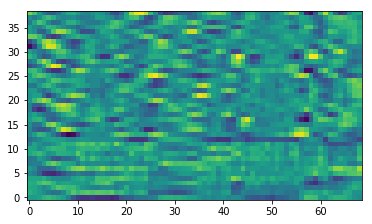

In [9]:
plt.imshow(train_x[3277].T, origin="bottom");

In [10]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [11]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

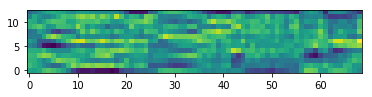

In [12]:
plt.imshow(train_x[3277].T, origin="bottom");

## Multi-layer Siamese triplets model

In [13]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
train_matches_vec = generate_matches_array(train_labels)

# Model parameters
n_input = d_frame
rnn_n_hiddens = [400, 400, 400]
ff_n_hiddens = [130]
margin = 0.15
rnn_type = "gru"  # "lstm", "gru", "rnn"
intermediate_model_fn = path.join(output_dir, "siamese_triplets.tmp.ckpt")
model_fn = path.join(output_dir, "siamese_triplets.ckpt")

# Model
x_a = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_s = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_d = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_a_lengths = tf.placeholder(TF_ITYPE, [None])
x_s_lengths = tf.placeholder(TF_ITYPE, [None])
x_d_lengths = tf.placeholder(TF_ITYPE, [None])
rnn_a, rnn_s, rnn_d = build_siamese_triplets(
    x_a, x_s, x_d, build_siamese_rnn_side, {"rnn_n_hiddens": rnn_n_hiddens,
    "ff_n_hiddens": ff_n_hiddens, "rnn_type": rnn_type}, x_a_lengths,
    x_s_lengths, x_d_lengths
    )

# Contrastive loss
loss = tf.reduce_mean(tf.maximum(0., margin + cos_distance(rnn_a, rnn_s) - cos_distance(rnn_a, rnn_d)))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Test tensors
same_distance = tf.reduce_mean(cos_distance(rnn_a, rnn_s))
diff_distance = tf.reduce_mean(cos_distance(rnn_a, rnn_d))


In [14]:
def samediff_val():
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = SimpleIterator(
        val_x, len(val_x), False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x_padded, batch_x_lengths in val_batch_iterator:
            np_x = batch_x_padded
            np_x_lengths = batch_x_lengths
            np_z = session.run(
                [rnn_a], feed_dict={x_a: np_x, x_a_lengths: np_x_lengths}
                )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

#     # Same-different (with normalisation)
#     np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
#     distances = pdist(np_z_normalised, metric="cosine")
#     matches = samediff.generate_matches_array(labels)
#     ap, prb = samediff.average_precision(
#         distances[matches == True], distances[matches == False]
#         )
        
    # Same-different
    distances = pdist(np_z, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )    
    return [prb, -ap]

In [ ]:
# Training
np.random.seed(1)

train_batch_iterator = TripletsIterator(
    train_x, train_matches_vec, batch_size, True, True, None
    )

val_model_fn = intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x_a, x_s, x_d, x_a_lengths, x_s_lengths, x_d_lengths], samediff_val, save_model_fn=intermediate_model_fn, save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval
    )

2018-12-04 15:12:44.041189
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/siamese_triplets.tmp.ckpt
13.834 sec, train loss: 0.056268305, val loss: [0.05128189401567808, -0.01873167313020048] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/siamese_triplets.tmp.ckpt
12.250 sec, train loss: 0.030532638, val loss: [0.08219531048698789, -0.03294218890584657] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/siamese_triplets.tmp.ckpt
12.091 sec, train loss: 0.018589202, val loss: [0.11640487249866276, -0.05292841362285419] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/siamese_triplets.tmp.ckpt
12.081 sec, train loss: 0.012095028, val loss: [0.1319346030519053, -0.06783654349315686] *
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/siamese_triplets.tmp.ckpt
12.218 sec, train loss: 0.008272015, val loss: [0.1576646570517835, -0.08354086026149359] *
Epoch 5:
INFO:tensorflow:Restoring 

In [ ]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [rnn_a], feed_dict={x_a: np_x, x_a_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

In [ ]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

In [ ]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

In [ ]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )

## Multi-layer Siamese model with a semi-hard triplets loss

In [ ]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 50
n_val_interval = 1
n_buckets = 3
batch_size = 300  # 300 (tune)
train_matches_vec = generate_matches_array(train_labels)

# Model parameters
n_input = d_frame
rnn_n_hiddens = [400, 400, 400]  # (tune)
ff_n_hiddens = [130]
margin = 0.2  # 0.25 (tune)
rnn_type = "gru"  # "lstm", "gru", "rnn"
intermediate_model_fn = path.join(output_dir, "siamese_triplets.tmp.ckpt")
model_fn = path.join(output_dir, "siamese_triplets.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
y = tf.placeholder(TF_ITYPE, [None])
rnn = build_siamese_rnn_side(
    x, x_lengths, rnn_n_hiddens, ff_n_hiddens, rnn_type
    )
rnn = tf.nn.l2_normalize(rnn, axis=1)

# Contrastive loss
loss = tf.contrib.losses.metric_learning.triplet_semihard_loss(
    labels=y, embeddings=rnn, margin=margin
    )
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [ ]:
class SimpleLabelledIterator(object):
    """Iterator without bucketing with labels."""
    
    def __init__(self, x_list, y, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.y = y
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.indices = np.arange(len(self.x_lengths))
        self.shuffle()
    
    def shuffle(self):
        np.random.shuffle(self.indices)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]
            batch_y = self.y[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths, batch_y)

            
def get_pair_list(labels, both_directions=True):
    """Return a list of tuples giving indices of matching types."""
    N = len(labels)
    match_list = []
    for n in range(N - 1):
        cur_label = labels[n]
        for cur_match_i in (n + 1 + np.where(np.asarray(labels[n + 1:]) ==
                cur_label)[0]):
            match_list.append((n, cur_match_i))
            if both_directions:
                match_list.append((cur_match_i, n))
    return match_list

            
class LabelledBucketIterator(object):
    """Iterator with labels and bucketing."""
    
    def __init__(self, x_list, y, batch_size, n_buckets,
            shuffle_every_epoch=False):
        self.x_list = x_list
        self.y = y
        self.batch_size = int(np.floor(batch_size*0.5))  # batching is done over pairs, but target size given over items
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.pair_list = get_pair_list(y, both_directions=False)
#         self.n_batches = int(len(self.x_lengths)/batch_size)
        self.n_batches = int(len(self.pair_list)/self.batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort(
            [max(len(x_list[i]), len(x_list[j])) for i, j in self.pair_list]
            )
#         bucket_size = int(len(self.x_lengths)/self.n_buckets)
        bucket_size = int(len(self.pair_list)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(self.n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()

    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):
            
            batch_pair_list = [
                self.pair_list[i] for i in self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size]
                ]

            batch_indices = list(set([i for i, j in batch_pair_list] + [j for i, j in batch_pair_list]))
            
            batch_x_lengths = self.x_lengths[batch_indices]
            batch_y = self.y[batch_indices]
            
            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths, batch_y)


In [ ]:
def samediff_val():
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = SimpleIterator(
        val_x, len(val_x), False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x_padded, batch_x_lengths in val_batch_iterator:
            np_x = batch_x_padded
            np_x_lengths = batch_x_lengths
            np_z = session.run(
                [rnn], feed_dict={x: np_x, x_lengths: np_x_lengths}
                )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

#     # Same-different (with normalisation)
#     np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
#     distances = pdist(np_z_normalised, metric="cosine")
#     matches = samediff.generate_matches_array(labels)
#     ap, prb = samediff.average_precision(
#         distances[matches == True], distances[matches == False]
#         )
        
    # Same-different
    distances = pdist(np_z, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )    
    return [prb, -ap]

In [ ]:
# Training
np.random.seed(1)

train_batch_iterator = LabelledBucketIterator(
    train_x, train_y, batch_size, n_buckets=n_buckets, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, x_lengths, y], samediff_val, save_model_fn=intermediate_model_fn, save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval
    )

In [ ]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [rnn], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

In [ ]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

In [ ]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

In [ ]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )